In [123]:
# !python -m pip install gwpy
# !pip install astropy==4.2.1

In [124]:
# from google.colab import drive
# drive.mount('/content/gdrive')
# import os

# One time ONLY - Installation of Kaggle package
# !pip install --upgrade --force-reinstall --no-deps kaggle

# TO IMPORT DATA - ONE TIME CODE
# os.environ['KAGGLE_CONFIG_DIR']='/content/gdrive/MyDrive/Kaggle_Datasets'
# os.chdir('/content/gdrive/MyDrive/G2Net_Gravitational_Waves')
# !kaggle competitions download -c g2net-gravitational-wave-detection

#Unzip Data
# !unzip /content/gdrive/MyDrive/G2Net_Gravitational_Waves/g2net-gravitational-wave-detection.zip

In this competition you are provided with a training set of time series data containing simulated gravitational wave measurements from a network of 3 gravitational wave interferometers (LIGO Hanford, LIGO Livingston, and Virgo). Each time series contains either detector noise or detector noise plus a simulated gravitational wave signal. The task is to identify when a signal is present in the data (target=1).

So we need to use the training data along with the target value to build our model and make predictions on the test IDs in form of probability that the target exists for that ID.

So basically data-science helping here by building models to filter out this noises from data-streams (which includes both noise frequencies and Gravitational Waves frequencies) so we can single out frequencies for Gravitational-Waves. This is very well-explained by by Professor Rana Adhikari of Caltech and a member of the LIGO team, who were the first to measure gravitational waves. See his [interview here](https://youtu.be/1D2j8nTjOZ4?t=1946)


## Basic Description of the Data Provided

We are provided with a train and test set of time series data containing simulated gravitational wave measurements from a network of 3 gravitational wave interferometers:

- LIGO Hanford

- LIGO Livingston

- Virgo

Each time series contains either detector noise or detector noise plus a simulated gravitational wave signal.

The task is to identify when a signal is present in the data (target=1).

Each .npy data file contains 3 time series (1 coming for each detector) and each spans 2 sec and is sampled at 2,048 Hz.

And we have a total of 5,60,000 files, each file of dimension of 3 * 4096, this turns out to be a huge time series

In [125]:
import pandas as pd
import seaborn as sns
from scipy import signal
from gwpy.timeseries import TimeSeries
from gwpy.plot import Plot
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from PIL import Image
from glob import glob
from matplotlib import pyplot as plt
import random
from colorama import Fore, Back, Style
plt.style.use('ggplot')
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split

from tensorflow.keras.utils import Sequence

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv1D, MaxPool1D, BatchNormalization
from tensorflow.keras.optimizers import RMSprop, Adam

## Some basic definition

### What is this .NPY file?

It is a standard binary file format for persisting a single arbitrary NumPy array on disk. The format stores all of the shape and data type information necessary to reconstruct the array correctly even on another machine with a different architecture. The format is designed to be as simple as possible while achieving its limited goals. The implementation is intended to be pure Python and distributed as part of the main numpy package.

**This file format makes incredibly fast reading speed enhancement over reading from plain text or CSV files.**

### Sampling frequency in a TimeSeries

The sampling frequency, or sample rate, is the number of equal-spaced samples per unit of time. For instance, if you have 96 equally spaced observation per day, then you sampling rate is 96/day, or 96/24/3600=0.0011 Hz. Hz, which means per second, is widely used for sample rate.

In [126]:
# Checking the contents of one file
root_dir = "../input/g2net-gravitational-wave-detection"
# file = '../input/g2net-gravitational-wave-detection/train/0/0/0/000a5b6e5c.npy'
file = root_dir + '/train/0/0/0/000a5b6e5c.npy'
data = np.load(file)
print(data.shape)
print(data)
# print(data[0, :].shape)
# print(data[1, :].shape)
# print(data[2, :].shape)
print("data[0, :] is ", data[0, :])
# data_1

(3, 4096)
[[-3.82980864e-21 -3.88290722e-21 -3.89583068e-21 ...
   1.00965251e-20  9.68836567e-21  9.75052802e-21]
 [-5.39587907e-21 -5.86718917e-21 -5.59127863e-21 ...
  -3.90359733e-21 -4.08026656e-21 -3.59755890e-21]
 [-2.08338130e-21 -2.78123460e-21 -2.56792922e-21 ...
   1.62472677e-21  1.92169973e-21  1.69866822e-21]]
data[0, :] is  [-3.82980864e-21 -3.88290722e-21 -3.89583068e-21 ...
  1.00965251e-20  9.68836567e-21  9.75052802e-21]


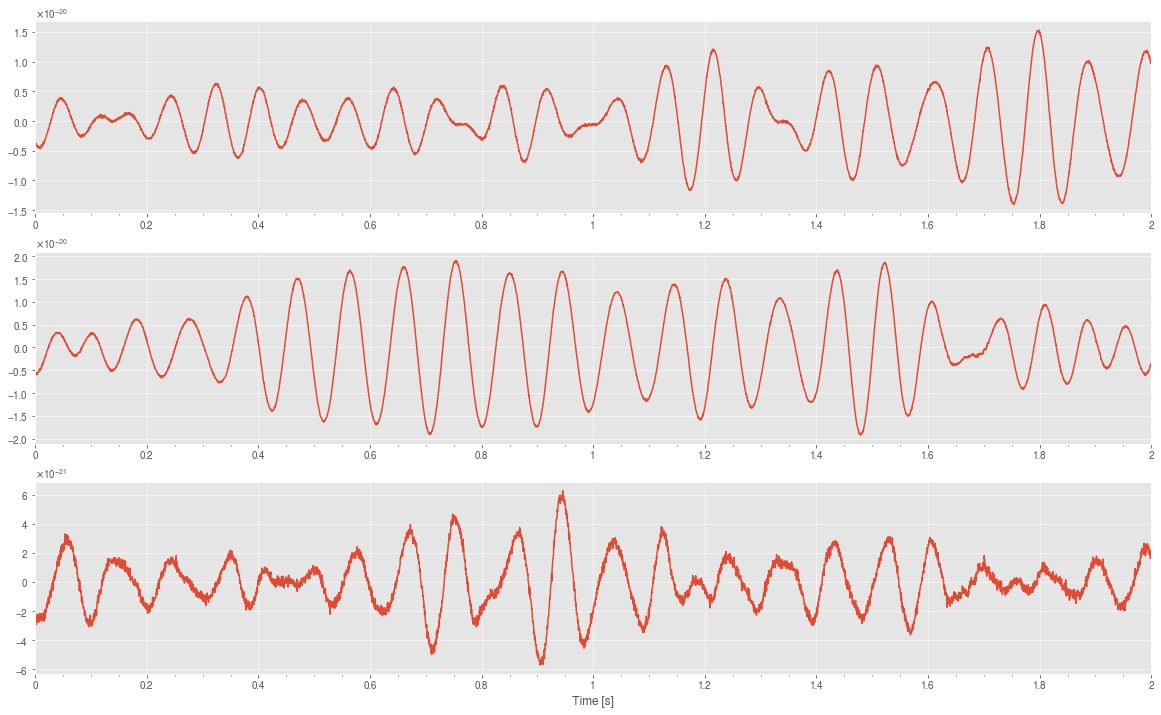

In [127]:
# The gwpy's TimeSeries function expects array-like input data array as its first argument
# and sample_rate : float, Quantity, optional the rate of samples per second (Hertz)
def get_tseries_from_file(file_name):
  t_data = np.load(file_name)
  tseries1 = TimeSeries(t_data[0,:], sample_rate=2048)
  tseries2 = TimeSeries(t_data[1,:], sample_rate=2048)
  tseries3 = TimeSeries(t_data[2,:], sample_rate=2048)
  return tseries1, tseries2, tseries3

''' Multi-data plots with gwpy.plot

https://gwpy.github.io/docs/latest/plot/index.html#multi-data-plots - 

GWpy enables trivial generation of plots with multiple datasets. The Plot constructor will accept an arbitrary collection of data objects and will build a figure with the required geometry automatically. By default, a flat set of objects are shown on the same axes: 

separate=True can be given to show each dataset on a separate Axes

The returned object is a Plot, a sub-class of matplotlib.figure. Figure adapted for GPS time-stamped data. Customisations of the figure or the underlying Axes can be done using standard matplotlib methods. Hence I can use .gca()

.gac() - Get the current Axes instance on the current figure matching the given keyword args, or create one. The plt.gca() function gets the current axes so that you can draw on it directly. 

https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.gca.html

'''

def plot_tseries(t1, t2, t3):
  plot = Plot(t1, t2, t3, separate=True, sharex=True, figsize=[20, 12])
  ax = plot.gca()
  ax.set_xlim(0, 2)
  ax.set_xlabel('Time [s]')
  plt.show()
  
file_1 = '../input/g2net-gravitational-wave-detection/train/0/0/0/000a5b6e5c.npy'
  
tseries1, tseries2, tseries3 = get_tseries_from_file(file_1)

# Plotting the 3 TimeSeries
plot_tseries(tseries1, tseries2, tseries3)
  

# Load the .npy files from all the nested folder-structure and get the ids from file names

In [128]:
train_labels = pd.read_csv(root_dir + "/training_labels.csv")
print(Fore.YELLOW + 'Dataset has ', Style.RESET_ALL + "{} Observations".format(train_labels.shape[0]) )

print(Fore.MAGENTA + "Printing first 5 Labels: ", Style.RESET_ALL )
display(train_labels.head())

Dataset has  560000 Observations
Printing first 5 Labels:  


,id,target
0,00000e74ad,1
1,00001f4945,0
2,0000661522,0
3,00007a006a,0
4,0000a38978,1


In [129]:
# Construct a Training dataframe for all the available .npy files 

# Get all the file file path from all 4-labels of nested folder structure
files_paths = glob(root_dir + '/train/*/*/*/*')
''' The glob module finds all the pathnames matching a specified pattern according to the rules 
used by the Unix shell, although results are returned in arbitrary order. 
No tilde expansion is done, but *, ?, and character ranges expressed with [] will be correctly matched. 
We can use glob to search for a specific file pattern, or perhaps more usefully, search for files where the 
filename matches a certain pattern by using wildcard characters.

'''

# get the list of ids from the .npy files
ids_from_npy_files = [path.split("/")[-1].split(".")[0] for path in files_paths]
# [-1] means the last element in a sequence,
# print(ids_from_npy_files)

# get a dataframe with paths and ids of those .npy files
df_path_id = pd.DataFrame({'path': files_paths, 'id':ids_from_npy_files})
df_path_id.head()

# merging that above df with the target
df_train = pd.merge(left=train_labels, right=df_path_id, on='id')
display(df_train.head())

# verifying the shape of the merged df has 5,60,000 rows and 3 columns
print(df_train.shape)


,id,target,path
0,00000e74ad,1,../input/g2net-gravitational-wave-detection/tr...
1,00001f4945,0,../input/g2net-gravitational-wave-detection/tr...
2,0000661522,0,../input/g2net-gravitational-wave-detection/tr...
3,00007a006a,0,../input/g2net-gravitational-wave-detection/tr...
4,0000a38978,1,../input/g2net-gravitational-wave-detection/tr...


(560000, 3)


In [130]:
# Classify the the 2 classes of targets of 1 and 0
target_1_df_train = df_train[df_train.target == 1]
target_0_df_train = df_train[df_train.target == 0]
print("Class distribution of Target: \n ", train_labels.target.value_counts())
display(target_1_df_train.head())

Class distribution of Target: 
  0    280070
1    279930
Name: target, dtype: int64


,id,target,path
0,00000e74ad,1,../input/g2net-gravitational-wave-detection/tr...
4,0000a38978,1,../input/g2net-gravitational-wave-detection/tr...
5,0000bb9f3e,1,../input/g2net-gravitational-wave-detection/tr...
7,0000d61b7b,1,../input/g2net-gravitational-wave-detection/tr...
8,0001016d12,1,../input/g2net-gravitational-wave-detection/tr...


Text(0.5, 1.0, 'Target Class Distribution')

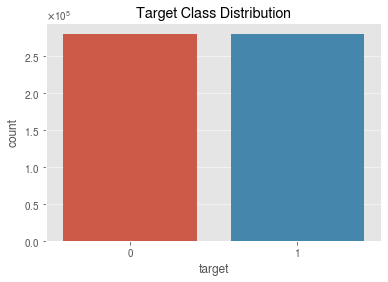

In [131]:
sns.countplot(x = 'target' , data=train_labels)
plt.title('Target Class Distribution')

### Plotting (KDE, Boxplot, and Timeseries)

As we are provided with a train and test set of time series data from a network of 3 gravitational wave interferometers:

- LIGO Hanford

- LIGO Livingston

- Virgo


In [132]:
# Defining a multi-plot function
# And I am going to call the 3 series as Series-1, Series-2 and Series-3
def multi_plot(series, plot_type, target):
    if plot_type == 'box' or plot_type == 'kde':
      plt.figure(figsize=(20, 2))
    else:
      plt.figure(figsize=(15,12))

    for idx in range(3):
      if plot_type == 'box':
          plt.subplot(1, 3, idx+1)
          sns.boxplot(series[idx:idx+1], color = 'b')

      elif plot_type == 'kde':
            plt.subplot(1, 3, idx+1)
            sns.kdeplot(series[idx], color = 'g', shade=True, lw=2, alpha=0.5)
      else:
        plt.subplot(3, 1, idx+1) # As in the case of 'time' based plot, I wan 3 rows
        plt.plot(series[idx: idx+1].T, color= 'r')
        plt.title("\nSeries-" + str(idx+1))

    if plot_type == 'box':
      plt.suptitle("Box Plots(target = " + target + ")")
    elif plot_type == 'kde':
      plt.suptitle("Probability Distribution Plots(target = " + target + ")")
    else:
      plt.suptitle("Time Distribution of Signals - Spans 2 sec, Sampled at 2,048 Hz(target = " + target + ")")
        

  

../input/g2net-gravitational-wave-detection/train/5/e/2/5e259b581d.npy


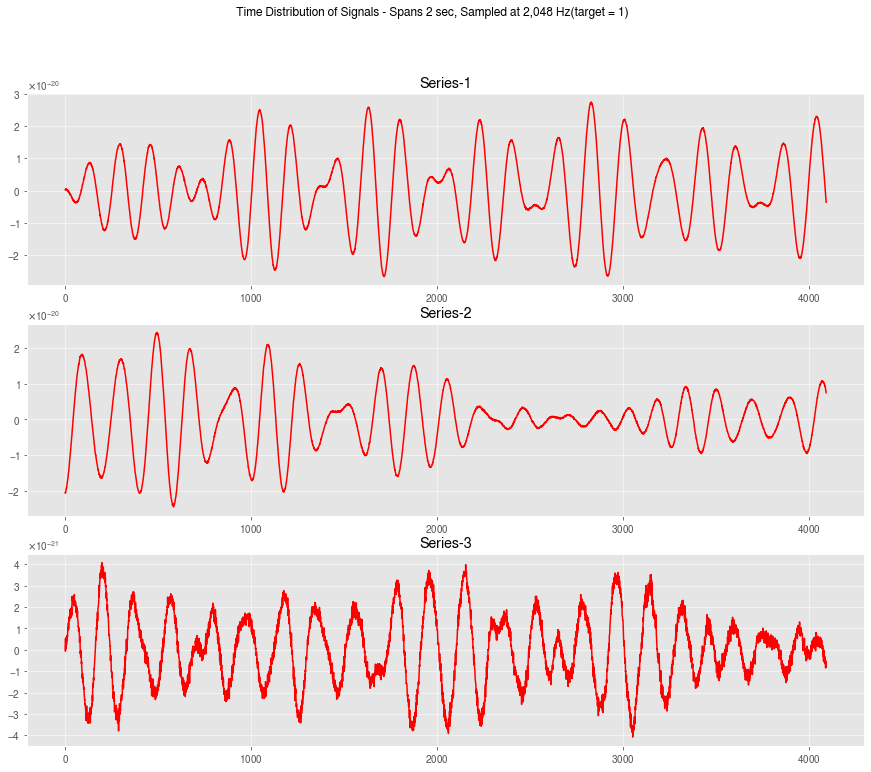

In [133]:
# Extract 1 random element from the target_1_df_train
# using random_state to ensure the reproducibility of the examples.
target_1_rand_sample_file = target_1_df_train.sample(1).path.values[0]
print(target_1_rand_sample_file)

selected_rand_series_1 = np.load(target_1_rand_sample_file)

multi_plot(selected_rand_series_1, 'time', "1")


../input/g2net-gravitational-wave-detection/train/4/e/0/4e02114f45.npy


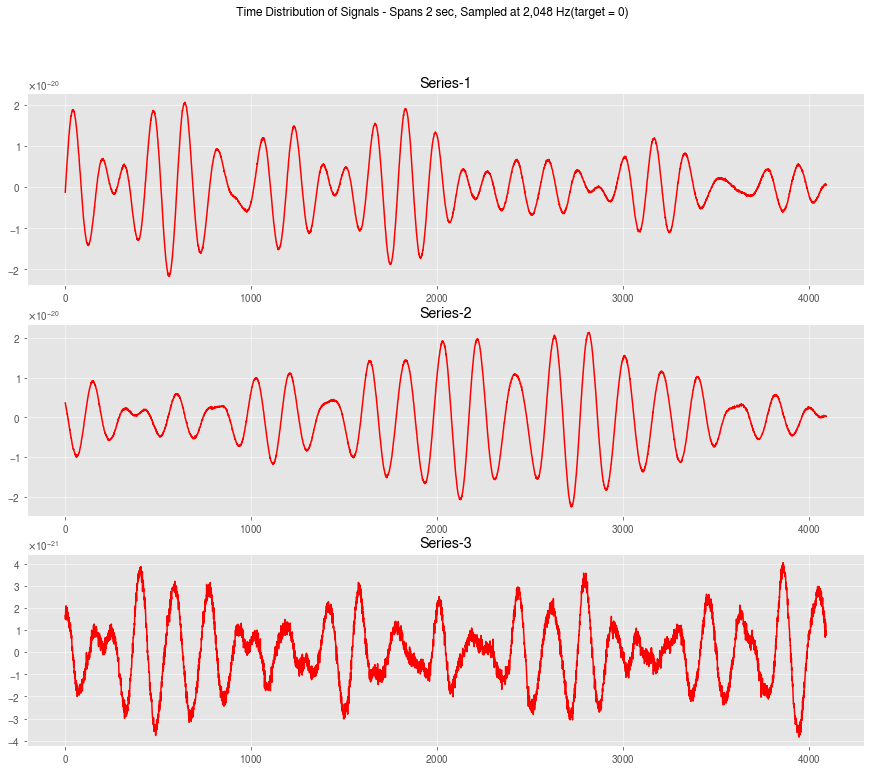

In [134]:
# Extract 1 random element from the target_0_df_train
# using random_state to ensure the reproducibility of the examples.
target_0_rand_sample_file = target_0_df_train.sample(1).path.values[0]
print(target_0_rand_sample_file)

selected_rand_series_0 = np.load(target_0_rand_sample_file)

multi_plot(selected_rand_series_0, 'time', "0")


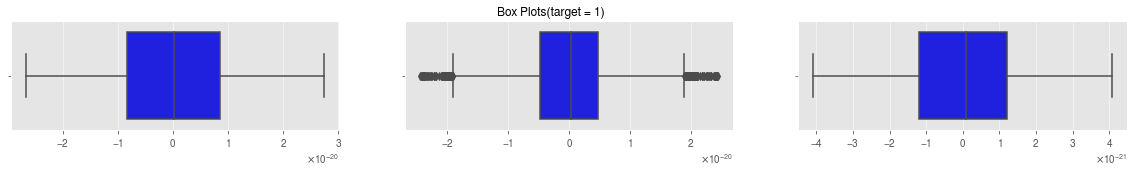

In [135]:
multi_plot(selected_rand_series_1, "box", "1")

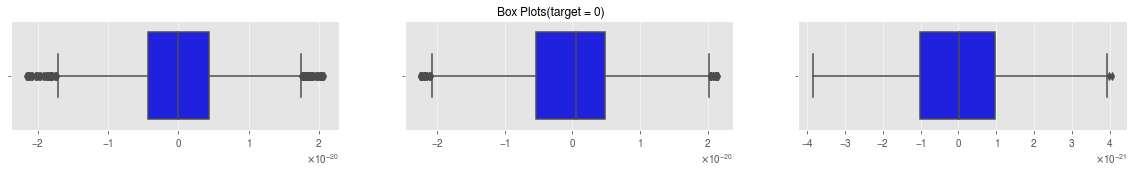

In [136]:
multi_plot(selected_rand_series_0, 'box', "0")

**Basic observation from Box Plots:**
1. The 3 series from the 3 Interferometer have fairly similar distribution for both the class types.

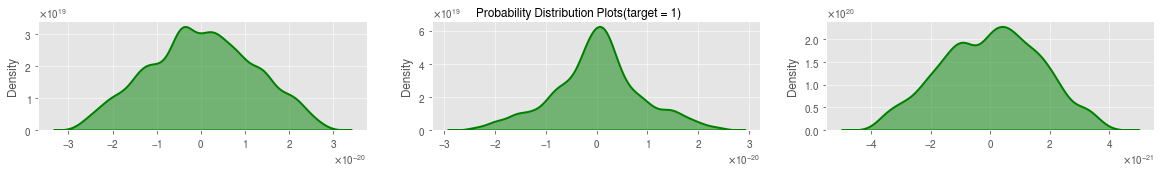

In [137]:
multi_plot(selected_rand_series_1, 'kde', "1")

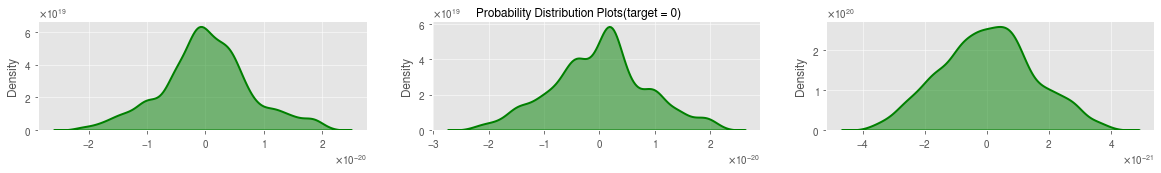

In [138]:
multi_plot(selected_rand_series_0, 'kde', "0")

In [139]:
""" First, we define the constructor to initialize the configuration of the generator.
Note that here, we assume the path to the data is in a dataframe column.

"""

class DataGenerator(Sequence):

    # For this dataset the list_IDs are the value of the ids
    # for each of the time-series file
    # i.e. for Train data => values of column 'id' from training_labels.csv

    # Also Note we have earlier defined our labels to be the below
    # labels = pd.read_csv("../input/g2net-gravitational-wave-detection/training_labels.csv")
    # and the argument "data" is that label here.
    def __init__(self, path, list_IDs, data, batch_size):
        self.path = path
        self.list_IDs = list_IDs
        self.data = data
        self.batch_size = batch_size
        self.indexes = np.arange(len(self.list_IDs))

    """ __len__ essentially returns the number of steps in an epoch, using the samples and the batch size.
   Each call requests a batch index between 0 and the total number of batches, where the latter is specified in the __len__ method.
   A common practice is to set this value to (samples / batch size)
   so that the model sees the training samples at most once per epoch.
   Now, when the batch corresponding to a given index is called, the generator executes the __getitem__ method to generate it.
  """

    def __len__(self):
        len_ = int(len(self.list_IDs)/self.batch_size)
        if len_ * self.batch_size < len(self.list_IDs):
            len_ += 1
        return len_

    """  __getitem__ method is called with the batch number as an argument to obtain a given batch of data.

    """
    def __getitem__(self, index):
        # get the range to to feed to keras for each epoch
        # incrementing by +1 the bath_size
        indexes = self.indexes[index * self.batch_size : (index + 1) * self.batch_size]
        list_IDs_temp = [self.list_IDs[k] for k in indexes]
        X, y = self.__data_generation(list_IDs_temp)
        return X, y

    """ And finally the core method which will actually produce batches of data. This private method __data_generation """

    def __data_generation(self, list_IDs_temp):
        # We have 5,60,000 files, each with dimension of 3 * 4096
        X = np.zeros((self.batch_size, 3, 4096))
        y = np.zeros((self.batch_size, 1))
        for i, ID in enumerate(list_IDs_temp):
            id_ = self.data.loc[ID, "id"]
            file = id_ + ".npy"  # build the file name
            path_in = "/".join([self.path, id_[0], id_[1], id_[2]]) + "/"
            # there are three nesting labels inside train/ or test/
            data_array = np.load(path_in + file)            
            data_array = (data_array - data_array.mean())/data_array.std()
            X[i, ] = data_array
            y[i, ] = self.data.loc[ID, 'target']
        # print(X)
        return X, y

In [140]:
sample_submission = pd.read_csv('../input/g2net-gravitational-wave-detection/sample_submission.csv')
train_ids = train_labels['id'].values
# train_ids # ['00000e74ad', '00001f4945', '0000661522' ... ]
y = train_labels['target'].values
test_ids = sample_submission['id'].values

In [141]:
# train_labels = pd.read_csv("../input/g2net-gravitational-wave-detection/training_labels.csv", nrows=1000)
# Now I shall genereate train indices, validation indices and test indices
# Which are just the values from the 0-based indices
train_indices, validation_indices = train_test_split(list(train_labels.index), test_size=0.33, random_state=2021)
# print(len(train_indices))
print(len(validation_indices))
test_indices = list(sample_submission.index)
# test_indices

184800


In [142]:

train_generator_for_seq_model = DataGenerator('../input/g2net-gravitational-wave-detection/train/', train_indices, train_labels, 64)
# print(train_generator_for_seq_model)
validation_generator_for_seq_model = DataGenerator('../input/g2net-gravitational-wave-detection/train/', validation_indices, train_labels, 64)
test_generator_for_seq_model = DataGenerator('../input/g2net-gravitational-wave-detection/test/', test_indices, sample_submission, 64)

In [143]:
model_keras_seq = Sequential()
model_keras_seq.add(Conv1D(64, input_shape=(3, 4096), kernel_size=3, activation='relu'))
model_keras_seq.add(BatchNormalization())
model_keras_seq.add(Flatten())
model_keras_seq.add(Dense(64, activation='relu'))
model_keras_seq.add(Dense(1, activation='sigmoid'))

model_keras_seq.compile(optimizer= Adam(lr=2e-4), loss='binary_crossentropy', metrics=['acc'])
model_keras_seq.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_13 (Conv1D)           (None, 1, 64)             786496    
_________________________________________________________________
batch_normalization_12 (Batc (None, 1, 64)             256       
_________________________________________________________________
flatten_12 (Flatten)         (None, 64)                0         
_________________________________________________________________
dense_24 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_25 (Dense)             (None, 1)                 65        
Total params: 790,977
Trainable params: 790,849
Non-trainable params: 128
_________________________________________________________________


In [ ]:
history = model_keras_seq.fit_generator(generator=train_generator_for_seq_model, validation_data=validation_generator_for_seq_model, epochs = 1, workers=-1)